# Title
and Summary

## Data Overview

notes

In [1]:
# !pip install utm # Ran once

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6109 sha256=97b05bd3b4c05b1be5241244705079469fca93953f96d32ce3bd7b7faa6c30af
  Stored in directory: /home/exouser/.cache/pip/wheels/75/f0/dd/39dfc9436520412399934d4a8566fe5c0cb8cc2568a1196057
Successfully built utm


In [27]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import imageio.plugins.ffmpeg as ffmpeg

Load and process data (there's an error printed, but I think it might be fine)

In [30]:
#Loading the data and splitting it in testing and training data
from io import StringIO
import numpy as np
import csv
import math
import utm
import os

from sklearn.model_selection import train_test_split

# Cue up folders to check (MODIFY with addition or removal of folders)
data_folders = ['r3/','r4/','s1/']

# Sets to be filled
labels = []
images = []

# Check each folder in cue
for folder in data_folders:

    # Load image filenames
    img_path = './data/' + folder
    img_filenames = os.listdir(img_path)

    # Load CSV data
    csv_path = img_path + "/im_info.csv"
    with open(csv_path, 'r') as x:
        csv_data = list(csv.reader(x, delimiter=","))

    # Load data into np array and delete title row element
    csv_data = np.array(csv_data)
    csv_data = np.delete(csv_data,0)
    
    # Begin formatting data
    print('Formatting Data for', folder ,'...')
    print('Number of datapoints:', len(csv_data))

    for i in range(0,len(csv_data)-2):
        # Load image
        image = img_path+img_filenames[i]
        if ('.csv' or '.ipynb_checkpoints') in image: continue
        
        # Load current data and data 1/3s into future (for next imgage)
        # Vals loaded from each line are [timestamp, yaw, lat, lon]
        curr_line = csv_data[i]
        curr_vals =  np.float_([curr_line[1],curr_line[4],curr_line[6],curr_line[7]])
        next_line = csv_data[i+1]
        next_vals =  np.float_([next_line[1],next_line[4],next_line[6],next_line[7]])
    
        curr_coord = utm.from_latlon(curr_vals[2], curr_vals[3])
        next_coord = utm.from_latlon(next_vals[2], next_vals[3])
    
        time_change = next_vals[0] - curr_vals[0] # change in time (may be unused)
        angle_change = next_vals[1] - curr_vals[1] # change that should be commanded to current steering angle
        # distance_change = abs(math.dist([curr_vals[2],curr_vals[3]],[next_vals[2],next_vals[3]])) # NOTE - this is lat/lon so values are small
        distance_change = abs(math.dist([curr_coord[0],curr_coord[1]],[next_coord[0],next_coord[1]]))
        velocity = distance_change/time_change # velocity that should be commanded
    
        label = [angle_change, velocity] # angle change is in degrees (I think), velocity units are __
    
        images.append(image)
        labels.append(label)


data_images = np.array(images)
data_labels = np.array(labels)

print('Formatting Complete')
print('=============================')

# Split data into training and testing sets
img_train, img_test, label_train, label_test = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)

# Print the size of the resulting datasets
print(f"Training image data size: {len(img_train)}")
print(f"Testing image data size: {len(img_test)}")
print(f"Training label data size: {len(label_train)}")
print(f"Testing label data size: {len(label_test)}")

/tmp/ipykernel_3972/2992737728.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  csv_data = np.array(csv_data)


Formatting Data for r3/ ...
Number of datapoints: 544
Formatting Data for r4/ ...
Number of datapoints: 524
Formatting Data for s1/ ...
Number of datapoints: 581
Formatting Complete
Training image data size: 1311
Testing image data size: 328
Training label data size: 1311
Testing label data size: 328


Load an image and check out labeling

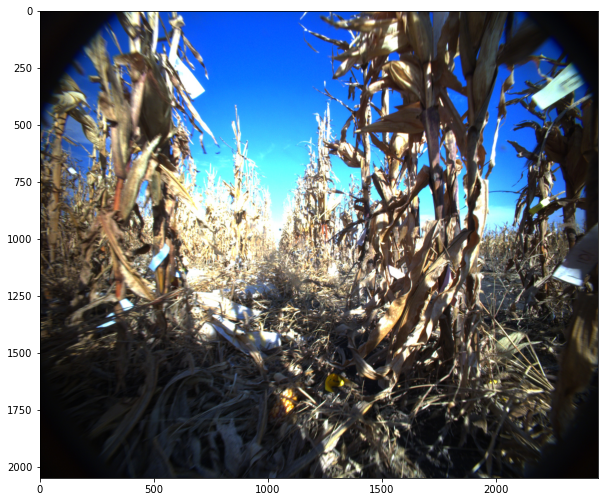

Steering Change to Make: -3.0507795381696727 | Velocity to Command: 1.0128892721459237


In [31]:
import random

# Select a random image from the list
img_rand = random.randint(0,len(img_train))

image = img_train[img_rand]

label = label_train[img_rand]

# Load the image using matplotlib
img = mpimg.imread(image)

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# Print label
print('Steering Change to Make:',label[0], '| Velocity to Command:', label[1])

Prepare custom dataloader

In [32]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image

class MaizeRoverDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path = self.images[idx] # './data/IMG_data/' + self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



### Define CNNs for training

Below CNN was developed for HW3 Rover Problem

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class MaizeRoverCNN_Simple(nn.Module):
    def __init__(self):
        super(MaizeRoverCNN_Simple, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) #in channels, out channels, kernel size, stride (opt.)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 4) # unused currently
        self.fc1 = nn.Linear(1438208, 360)
        self.fc2 = nn.Linear(360, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x,1) # flatten or view??
        
        x = F.relu(self.fc1(x)) # Change shape for fc layers
        x = F.relu(self.fc2(x))
        x = self.fc3(x)      
        return x


### Prepare Data for Training

<function matplotlib.pyplot.show(close=None, block=None)>

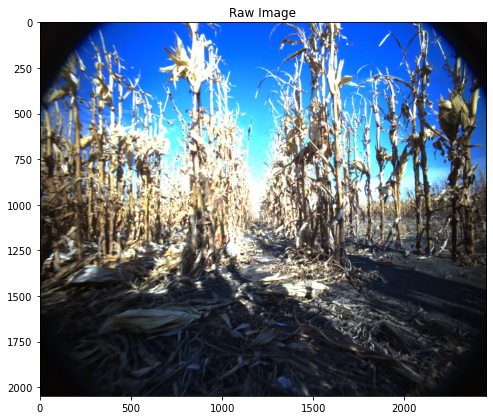

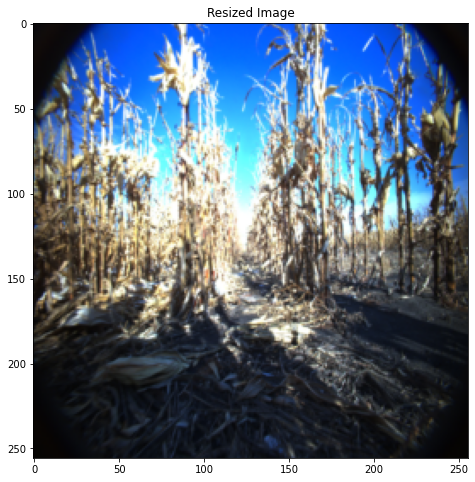

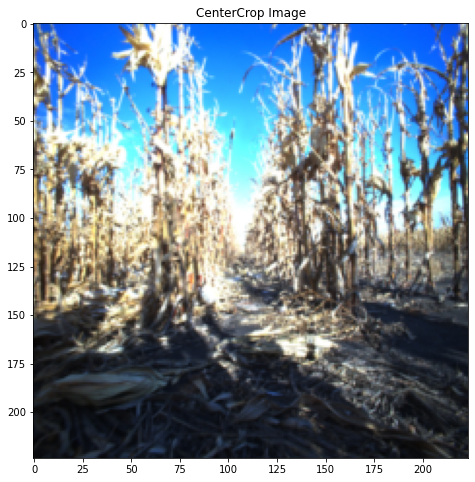

In [34]:
# TRANFORM TESTING (MAY DELETE LATER!!)
import torch
import torchvision
from PIL import Image
# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# First Transform
transform=transforms.Compose([
            transforms.Resize((256,256))])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('Resized Image')
plt.show

# Second Transform
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
            # transforms.ToTensor()])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('CenterCrop Image')
plt.show

In [35]:
# PAREMETERS FOR MODEL TRAINING
BATCH_SIZE = 32
EPOCHS = 5

# TRAINING AND VALIDATION SPLIT
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

#Define image transform used
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()]) 

In [44]:
#Load Training and Testing Data
from torch.utils.data import DataLoader
from torch.utils.data import random_split
           
# load datasets
training_data = MaizeRoverDataset(img_train, label_train, transform)
test_data = MaizeRoverDataset(img_test, label_test, transform)

# do train/validation split
numTrainSamples = int(math.ceil(len(training_data) * TRAIN_SPLIT))
numValSamples = int(math.floor(len(training_data) * VAL_SPLIT))
print('TrainSamps:',numTrainSamples,'ValSamps:',numValSamples,
      'Total:', numTrainSamples+numValSamples)


(train_data, val_data) = random_split(training_data, 
                                    [numTrainSamples, numValSamples],
                                    generator=torch.Generator().manual_seed(42))

# New data loaders
train_loader =  DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader.dataset) // BATCH_SIZE
testSteps = len(test_loader.dataset) // BATCH_SIZE

TrainSamps: 984 ValSamps: 327 Total: 1311


#### BASIC TRAINING SETUP FROM HW3

In [37]:
import time

# initialize model and training parameters
model = MaizeRoverCNN_Simple()
lossFn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #opt = Adam(model.parameters(), lr=INIT_LR)

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": []
}

# measure how long training is going to take
print("====Training the network====")
startTime = time.time()

n_minibatches = len(train_loader)

# ------------------START TRAINING LOOP------------------
for epoch in range(0,EPOCHS):    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    running_loss = 0.0
    epoch_time = time.time()
    print_every = n_minibatches // 10
    # total_train_loss = 0
    
    print("EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("==============================")
    
    # DO TRAINING
    # loop over training set
    for i, data in enumerate(train_loader):
        inputs, labels = data
        model.train()
        
        # perform forward pass and calculate training loss
        pred = model(inputs)
        loss = lossFn(pred, labels.float())
        
        # zero gradients, do backprop, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        # totalTrainLoss += loss
        
        # print every 10th of epoch
        if (i + 1) % (print_every + 1) == 0:    
            print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                time.time() -epoch_time))
            running_loss = 0.0
            epoch_time = time.time()
        
        # add the loss to the total training loss so fars
        totalTrainLoss += loss

        
    print('Training Step Done, Evaluating with Validation Data...')
    
    # EVALUATE WITH VALIDATION DATA
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for data in val_loader:
            inputs, labels = data
            
            # make predictions and calculate the validation loss
            pred = model(inputs)
            totalValLoss += lossFn(pred, labels.float())
            
 
    # PRINT STATISTICS
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
        
	# update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    # H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    # H["val_acc"].append(valCorrect)
    
	# print the model training and validation information
    print("Train loss: {:.6f}".format(avgTrainLoss))
    print("Val loss: {:.6f}\n".format(avgValLoss))

# ------------------END TRAINING LOOP------------------ 
    
# finish measuring how long training took
endTime = time.time()
print("====Training complete====")
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

====Training the network====
EPOCH: 1/5
Epoch 1, 12% 	 train_loss: 2.76 took: 19.76s
Epoch 1, 25% 	 train_loss: 3.25 took: 19.65s
Epoch 1, 38% 	 train_loss: 4.24 took: 19.70s
Epoch 1, 51% 	 train_loss: 3.01 took: 19.86s
Epoch 1, 64% 	 train_loss: 3.66 took: 19.95s
Epoch 1, 77% 	 train_loss: 3.24 took: 19.68s
Epoch 1, 90% 	 train_loss: 2.32 took: 19.65s
Training Step Done, Evaluating with Validation Data...
Train loss: 2.445658
Val loss: 2.196688

EPOCH: 2/5
Epoch 2, 12% 	 train_loss: 3.96 took: 19.85s
Epoch 2, 25% 	 train_loss: 4.01 took: 19.67s
Epoch 2, 38% 	 train_loss: 2.61 took: 19.75s
Epoch 2, 51% 	 train_loss: 2.15 took: 19.58s
Epoch 2, 64% 	 train_loss: 2.91 took: 19.67s
Epoch 2, 77% 	 train_loss: 3.25 took: 19.47s
Epoch 2, 90% 	 train_loss: 3.21 took: 19.57s
Training Step Done, Evaluating with Validation Data...
Train loss: 2.359530
Val loss: 2.150047

EPOCH: 3/5
Epoch 3, 12% 	 train_loss: 2.32 took: 19.55s
Epoch 3, 25% 	 train_loss: 2.79 took: 19.59s
Epoch 3, 38% 	 train_loss:

In [45]:
# ------------------RUN TEST DATA----------------------
totalTestLoss = 0

# switch off autograd for evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
        
    # loop over the test set
    for data in test_loader:
        inputs, labels = data
            
        # make predictions and calculate the test loss
        pred = model(inputs)
        totalTestLoss += lossFn(pred, labels.float())
        
# calculate the average test loss
avgTestLoss = totalTrainLoss / testSteps
        
# update our training history
    
# print the model training and validation information
print("Test loss: {:.6f}".format(avgTestLoss))

Test loss: 7.131402


SAVE

In [39]:
# Save entire model
# Specify a path
PATH = "basic_model.pt"

# Save
torch.save(model, PATH)

# Load
load_model = torch.load(PATH)
load_model.eval()

MaizeRoverCNN_Simple(
  (conv1): Conv2d(3, 6, kernel_size=(6, 6), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1438208, out_features=360, bias=True)
  (fc2): Linear(in_features=360, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

EVALUATE LOSS

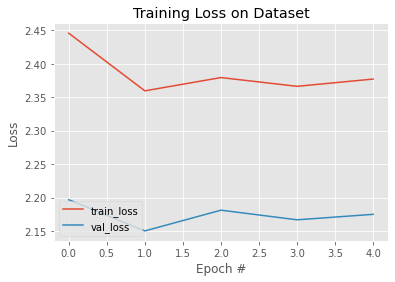

In [38]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

EVALUATE PERFORMANCE WITH SELECTED TEST IMAGES

Evaluating network with Testing Data...


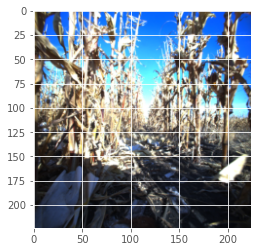

PREDICTED STEERING (de-normalized): 0.06746073067188263
ACTUAL STEERING (de-normalized):  -0.24906059471357356
PREDICTED THROTTLE:  0.7588852643966675
ACTUAL THROTTLE:  1.1352569329559588


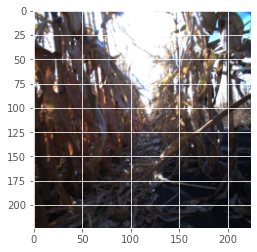

PREDICTED STEERING (de-normalized): 0.059456080198287964
ACTUAL STEERING (de-normalized):  -2.7630220089965576
PREDICTED THROTTLE:  0.7571196556091309
ACTUAL THROTTLE:  0.7043111332540354


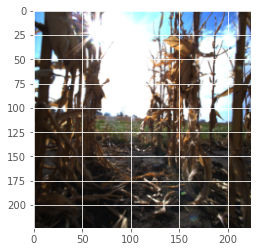

PREDICTED STEERING (de-normalized): 0.06131358444690704
ACTUAL STEERING (de-normalized):  -0.001486060003202283
PREDICTED THROTTLE:  0.7736895084381104
ACTUAL THROTTLE:  0.009859179392082041


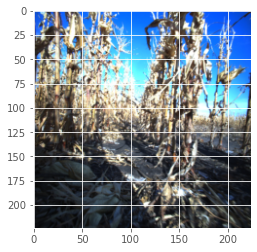

PREDICTED STEERING (de-normalized): 0.06443032622337341
ACTUAL STEERING (de-normalized):  -0.034595434957330085
PREDICTED THROTTLE:  0.7560432553291321
ACTUAL THROTTLE:  0.012713781708043935


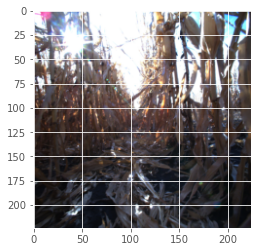

PREDICTED STEERING (de-normalized): 0.05702771991491318
ACTUAL STEERING (de-normalized):  -0.13111579239742355
PREDICTED THROTTLE:  0.7536958456039429
ACTUAL THROTTLE:  0.8907679879950342
Evaluation Complete


In [42]:
import torch
import torchvision
from PIL import Image
# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

print("Evaluating network with Testing Data...")

PATH = "basic_model.pt"
NUM_SAMPLES = 5

#Load saved model
model = torch.load(PATH)
torch.no_grad()
model.eval()

#Load Random Image
single_test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

ct = 1;
for inputs, labels in single_test_loader:
    pred = model(inputs)
    
    img = np.transpose(inputs[0], (1, 2, 0))
    plt.imshow(img)
    plt.show()
    # print(labels)    

    print("PREDICTED STEERING (de-normalized):", pred[0,0].item())
    print("ACTUAL STEERING (de-normalized): ", labels[0,0].item())
    print("PREDICTED THROTTLE: ", pred[0,1].item())
    print("ACTUAL THROTTLE: ", labels[0,1].item())
    print("=============================")
    
    if ct == NUM_SAMPLES: break
    ct += 1
    
print("Evaluation Complete")

#### GAURAV'S BETTER TRAINING SETUP FROM HW3

In [ ]:
import time

# initialize model and training parameters
model = RoverCNN()
lossFn = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 


# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": []
}

# measure how long training is going to take
print("====Training the network====")
startTime = time.time()

n_minibatches = len(train_loader)

# ------------------START TRAINING LOOP------------------
for epoch in range(0,EPOCHS):    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    running_loss = 0.0
    epoch_time = time.time()
    print_every = n_minibatches // 10
    # total_train_loss = 0
    
    print("EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("==============================")
    
     # DO TRAINING
    # loop over training set
    for i, data in enumerate(train_loader):
        inputs, labels = data
        model.train()
        
        # perform forward pass and calculate training loss
        pred = model(inputs)
        loss = lossFn(pred, labels.float())
        
        # zero gradients, do backprop, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        # totalTrainLoss += loss
        
        # print every 10th of epoch
        if (i + 1) % (print_every + 1) == 0:    
            print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                time.time() -epoch_time))
            running_loss = 0.0
            epoch_time = time.time()
        
        # add the loss to the total training loss so fars
        totalTrainLoss += loss

        
    print('Training Step Done, Evaluating with Validation Data...')
    
    # EVALUATE WITH VALIDATION DATA
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for data in val_loader:
            inputs, labels = data
            
            # make predictions and calculate the validation loss
            pred = model(inputs)
            totalValLoss += lossFn(pred, labels.float())
            
 
    # PRINT STATISTICS
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
        
	# update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    # H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    # H["val_acc"].append(valCorrect)
    
	# print the model training and validation information
    print("Train loss: {:.6f}".format(avgTrainLoss))
    print("Val loss: {:.6f}\n".format(avgValLoss))

# ------------------END TRAINING LOOP------------------ 
    
# finish measuring how long training took
endTime = time.time()
print("====Training complete====")
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

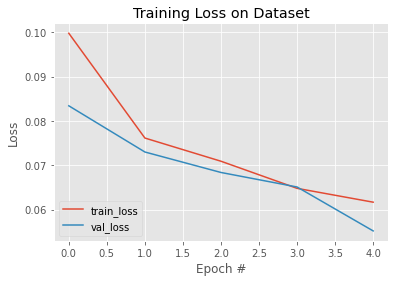

In [14]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")